In [1]:
# Allow Collab to connect to your Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to the data on Drive
root = "/content/drive/MyDrive/PhD/Integrated_Gradient"


Mounted at /content/drive


In [2]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torchsummary import summary
from math import floor
import matplotlib.pyplot as plt


In [3]:
!pip install torchsummary

In [4]:
# Checking if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    use_cuda = True
else:
    device = torch.device("cpu")
    use_cuda = False
print("Found:",torch.cuda.device_count(), device)


Found: 1 cuda


In [10]:
class VAE(nn.Module):
    def __init__(self, latent_dim, hidden_size):
        super().__init__()
        self.name = "vanilla_VAE"
        self.latent_dim = latent_dim
        self.hidden_size = hidden_size

        self.fc1 = nn.Linear(784, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_dim)
        self.fc22 = nn.Linear(hidden_size, latent_dim)
        self.fc3 = nn.Linear(latent_dim, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [5]:
class ConvVAE(nn.Module):
    def __init__(self):
        self.name = "Conv_VAE"
        super(ConvVAE, self).__init__()
        kernel_size      = 4   # (4 x 4)
        stride           = 2
        padding          = 1
        init_channels    = 16 # initial number of filters
        self.latent_dim  = 20 # latent dimension for sampling

        # Encoder
        # Conv1
        self.enc1 = nn.Conv2d(in_channels = 1, out_channels = init_channels, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((28 - kernel_size  + 2 * padding) / stride + 1)

        # Conv2
        self.enc2 = nn.Conv2d(in_channels = init_channels, out_channels = init_channels * 2, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((height_width - kernel_size  + 2 * padding) / stride + 1)

        # Conv3
        self.enc3 = nn.Conv2d(in_channels = init_channels * 2, out_channels = init_channels * 4, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = floor((height_width - kernel_size  + 2 * padding) / stride + 1)
        
        # fully connected layers for learning representations
        hidden_size = height_width ** 2 * init_channels * 4
        self.fc_mu = nn.Linear(hidden_size, self.latent_dim)
        self.fc_log_var = nn.Linear(hidden_size, self.latent_dim)
        self.fc2 = nn.Linear(self.latent_dim, init_channels * 4)
        
        

        # Decoder
        # ConvT  get width/height equal to kernel_size
        self.dec1 = nn.ConvTranspose2d(in_channels = init_channels * 4, out_channels = init_channels * 4, kernel_size = kernel_size, stride = 1, padding = 0)
        height_width = kernel_size
        
        # ConvT
        self.dec2 = nn.ConvTranspose2d(in_channels = init_channels * 4, out_channels = init_channels * 2, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = (height_width - 1) * stride - 2 * padding + kernel_size
        
        # ConvT
        self.dec3 = nn.ConvTranspose2d(in_channels = init_channels * 2, out_channels = init_channels, kernel_size = kernel_size, stride = stride, padding = padding)
        height_width = (height_width - 1) * stride - 2 * padding + kernel_size
        
        # ConvT adjust the padding so that we end up at 28x28
        required_padding = int(((height_width - 1) * stride + kernel_size - 28) / 2) 
        self.dec4 = nn.ConvTranspose2d(in_channels = init_channels, out_channels = 1, kernel_size = kernel_size, stride = stride, padding = required_padding)


    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        return mu + eps * std # sampling
        

    def encode(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        hidden = x.view(x.shape[0], -1)
        return self.fc_mu(hidden), self.fc_log_var(hidden)


    def decode(self, z):
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        return torch.sigmoid(self.dec4(x))


    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


In [6]:
# to debug
#model = VAE(20, 600).to(device)
model = ConvVAE().to(device)
print(model)
summary(model, (1, 28, 28))


ConvVAE(
  (enc1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=576, out_features=20, bias=True)
  (fc_log_var): Linear(in_features=576, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=64, bias=True)
  (dec1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(1, 1))
  (dec2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec3): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dec4): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3))
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             272
            Conv2d-2             [-1, 32, 7, 7]        

In [70]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [90]:
class Logger:
    " Simple logger to track progress during training"
    def __init__(self):
        self.losses_train = []
        self.losses_test = []

    def log(self, loss_train = 0, loss_test = 0):
        self.losses_train.append(loss_train)
        self.losses_test.append(loss_test)

def plot_learning_curve(train_curve, test_curve, ticks = 2):
    plt.figure()
    plt.plot(train_curve, label="Train")
    plt.plot(test_curve, label="Test")
    plt.legend(loc = 'best')
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.grid(True, alpha = 0.5)


In [76]:
def train(epoch, model, train_loader, optimizer, device, log_interval = 50):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
    return train_loss / len(train_loader.dataset)


In [77]:
def test(epoch, model, test_loader, device, batch_size = 128):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if epoch % 4 == 0 and i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                        recon_batch[:n]])
                save_image(comparison.cpu(),
                         root + '/results/VAE/recons/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

    return test_loss


In [78]:
def main(model, batch_size, epochs, lr = 5e-4):
    #torch.manual_seed(seed)
    kwargs = {'num_workers': 1, 'pin_memory': True}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(f"{root}/dataset/", train=True, download=True,
                    transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST(f"{root}/dataset/", train=False, transform=transforms.ToTensor()),
        batch_size=batch_size, shuffle=True, **kwargs)

    optimizer = optim.Adam(model.parameters(), lr = lr)
    logger = Logger()

    for epoch in range(1, epochs + 1):
        
        train_loss = train(epoch, model, train_loader, optimizer, device)
        test_loss = test(epoch, model, test_loader, device, batch_size)
        logger.log(train_loss, test_loss)

        if epoch % 4 == 0:
            with torch.no_grad():
                sample = torch.randn(64, model.latent_dim).to(device)
                sample = model.decode(sample).cpu()
                save_image(sample,
                        root + '/results/VAE/samples/sample_' + str(epoch) + '.png')
    torch.save(model.state_dict(), f"{root}/models/{model.name}.pt")

    return logger
    

In [81]:
#model = VAE(20, 600).to(device)
model = ConvVAE().to(device)
summary(model, (1, 28, 28))
logger = main(model, batch_size = 128, epochs = 80, lr = 1e-3)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             272
            Conv2d-2             [-1, 32, 7, 7]           8,224
            Conv2d-3             [-1, 64, 3, 3]          32,832
            Linear-4                   [-1, 20]          11,540
            Linear-5                   [-1, 20]          11,540
            Linear-6                   [-1, 64]           1,344
   ConvTranspose2d-7             [-1, 64, 4, 4]          65,600
   ConvTranspose2d-8             [-1, 32, 8, 8]          32,800
   ConvTranspose2d-9           [-1, 16, 16, 16]           8,208
  ConvTranspose2d-10            [-1, 1, 28, 28]             257
Total params: 172,617
Trainable params: 172,617
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.66
Estimated T

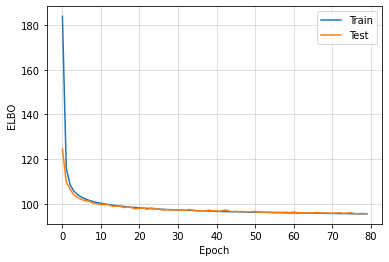

In [92]:
plot_learning_curve(logger.losses_train, logger.losses_test)
plt.savefig(f"{root}/results/VAE/{model.name}_loss.pdf", bbox_inches='tight')